In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
toxic = pd.read_csv("nlp/train.csv")

In [25]:
toxic

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0


preprocessing

In [5]:
toxic.drop(columns=['id'], inplace=True)

In [6]:
toxic.iloc[6]["comment_text"]

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

In [7]:
toxic[toxic.columns[1:]].iloc[6]

toxic            1
severe_toxic     1
obscene          1
threat           0
insult           1
identity_hate    0
Name: 6, dtype: int64

In [9]:
from tensorflow.keras.layers import TextVectorization

In [34]:
X = random_sample["comment_text"]
y = random_sample[toxic.columns[1:]].values

In [35]:
max_features = 20000

In [36]:
vectorizer = TextVectorization(max_tokens = max_features,
                               output_sequence_length = 1800,
                               output_mode = "int"
)

In [37]:
vectorizer.adapt(X.values)

In [ ]:
vectorizer.get_vocabulary()

In [38]:
vectorized_text = vectorizer(X.values)

In [39]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [40]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [54]:
len(train)

22

Model
Neural network


in this model i got random samples from my datas to train with high epochs
to find best model.
so need to train model on all datas.

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [57]:
y.shape

(500, 6)

In [63]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(max_features+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [64]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [ ]:
model.summary()

In [67]:
random_sample = toxic.sample(n=500, random_state=42)

In [68]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 26s 903ms/step - loss: 0.5926 - val_loss: 0.1845
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 863ms/step - loss: 0.1830 - val_loss: 0.1618
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 872ms/step - loss: 0.1567 - val_loss: 0.0672
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 860ms/step - loss: 0.1331 - val_loss: 0.1236
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 877ms/step - loss: 0.1184 - val_loss: 0.1962
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 872ms/step - loss: 0.1240 - val_loss: 0.0918
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 873ms/step - loss: 0.1019 - val_loss: 0.0234
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 870ms/step - loss: 0.0594 - val_loss: 0.0165
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 876ms/step - loss: 0.0507 - val_loss: 0.0327
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 871ms/step - loss: 0.0254 - val_loss: 0.0352


In [69]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

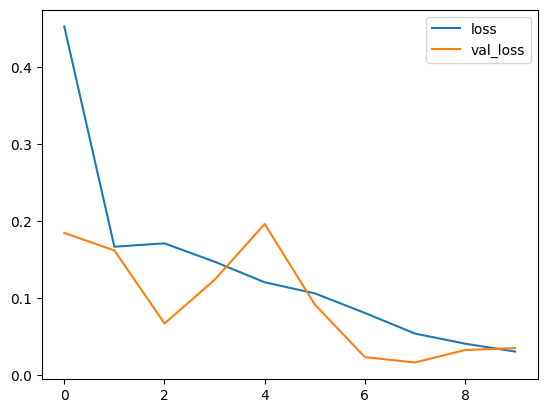

In [70]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

Prediction

In [32]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [36]:
result = model.predict(np.expand_dims(input_text,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


In [37]:
(result > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [41]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [42]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [40]:
toxic.columns[1:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [38]:
result

array([[0.9876276 , 0.23073868, 0.87549996, 0.02140433, 0.75496525,
        0.08859006]], dtype=float32)

Evaluate model

In [44]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [45]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [46]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [47]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8127246499061584, Recall:0.6363636255264282, Accuracy:0.4563691020011902


Test and Gradio

In [ ]:
!pip install gradio jinja2

In [50]:
import gradio as gr

In [51]:
model.save('toxicity.h5')

In [52]:
model = tf.keras.models.load_model('toxicity.h5')

In [53]:
input_str = vectorizer('hey i freaken hate you!')

In [55]:
result = model.predict(np.expand_dims(input_str,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


In [56]:
result

array([[0.37558097, 0.004694  , 0.07650954, 0.01415293, 0.10864264,
        0.0237447 ]], dtype=float32)

In [63]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(toxic.columns[1:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [65]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [66]:
interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7861

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


2024/11/21 18:18:24 [W] [service.go:132] login to server failed: connection write timeout


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Created dataset file at: .gradio\flagged\dataset1.csv
